# Imports

In [102]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomTreesEmbedding, VotingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

types = {k: np.int32 for k in range(21515)}

# Datensätze

LineUp mit Spielernamen

In [21]:
fifa_names = pd.read_csv("data/data_names.csv", encoding='utf8', index_col=None, header=None)

In [22]:
fifa_names.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.465510e+09,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Paul Pogba,...,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Ovidiu Hoban,Mihai Pintilii,Nicolae Stanciu,Adrian Popa,Florin Andone,Bogdan Stancu,1
1,1.465596e+09,Etrit Berisha,Ermir Lenjani,Elseid Hysaj,Lorik Cana,Ansi Agolli,Mergim Mavraj,Burim Kukeli,Taulant Xhaka,Odise Roshi,...,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,2
2,1.465942e+09,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Olivier Giroud,...,Ermir Lenjani,Elseid Hysaj,Ansi Agolli,Mergim Mavraj,Arlind Ajeti,Ledian Memushaj,Burim Kukeli,Amir Abrashi,Armando Sadiku,1
3,1.465942e+09,Ciprian Tătăruşanu,Răzvan Raţ,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Alexandru Chipciu,Mihai Pintilii,Gabriel Torje,Andrei Prepelită,...,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,0
4,1.466287e+09,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,...,Adil Rami,Bacary Sagna,Laurent Koscielny,Yohan Cabaye,Paul Pogba,Moussa Sissoko,Antoine Griezmann,André-Pierre Gignac,Kingsley Coman,0


In [23]:
fifa_names.drop([0], axis=1)

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
0,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Paul Pogba,Antoine Griezmann,...,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Ovidiu Hoban,Mihai Pintilii,Nicolae Stanciu,Adrian Popa,Florin Andone,Bogdan Stancu,1
1,Etrit Berisha,Ermir Lenjani,Elseid Hysaj,Lorik Cana,Ansi Agolli,Mergim Mavraj,Burim Kukeli,Taulant Xhaka,Odise Roshi,Amir Abrashi,...,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,2
2,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Olivier Giroud,Anthony Martial,...,Ermir Lenjani,Elseid Hysaj,Ansi Agolli,Mergim Mavraj,Arlind Ajeti,Ledian Memushaj,Burim Kukeli,Amir Abrashi,Armando Sadiku,1
3,Ciprian Tătăruşanu,Răzvan Raţ,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Alexandru Chipciu,Mihai Pintilii,Gabriel Torje,Andrei Prepelită,Claudiu Keșerü,...,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,0
4,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Breel Embolo,...,Adil Rami,Bacary Sagna,Laurent Koscielny,Yohan Cabaye,Paul Pogba,Moussa Sissoko,Antoine Griezmann,André-Pierre Gignac,Kingsley Coman,0
5,Joe Hart,Kyle Walker,Danny Rose,Gary Cahill,Chris Smalling,Raheem Sterling,Adam Lallana,Wayne Rooney,Eric Dier,Dele Alli,...,Sergey Ignashevich,Roman Neustädter,Vasiliy Berezutskiy,Georgiy Shchennikov,Aleksandr Golovin,Oleg Shatov,Aleksandr Kokorin,Fedor Smolov,Artem Dzyuba,0
6,Igor Akinfeev,Igor Smolnikov,Sergey Ignashevich,Roman Neustädter,Vasiliy Berezutskiy,Georgiy Shchennikov,Aleksandr Golovin,Oleg Shatov,Aleksandr Kokorin,Fedor Smolov,...,Martin Škrtel,Ján Ďurica,Tomáš Hubočan,Vladimír Weiss,Ondrej Duda,Marek Hamšík,Juraj Kucka,Viktor Pečovský,Róbert Mak,2
7,Joe Hart,Kyle Walker,Danny Rose,Gary Cahill,Chris Smalling,Raheem Sterling,Adam Lallana,Wayne Rooney,Eric Dier,Dele Alli,...,Neil Taylor,Ben Davies,James Chester,Ashley Williams,Joe Allen,Aaron Ramsey,Joe Ledley,Hal Robson-Kanu,Gareth Bale,1
8,Matúš Kozáčik,Peter Pekarík,Martin Škrtel,Ján Ďurica,Tomáš Hubočan,Vladimír Weiss,Ondrej Duda,Marek Hamšík,Juraj Kucka,Viktor Pečovský,...,Chris Smalling,Nathaniel Clyne,Ryan Bertrand,Adam Lallana,Jordan Henderson,Eric Dier,Jack Wilshere,Jamie Vardy,Daniel Sturridge,0
9,Igor Akinfeev,Igor Smolnikov,Sergey Ignashevich,Vasiliy Berezutskiy,Denis Glushakov,Pavel Mamaev,Roman Shirokov,Dmitriy Kombarov,Aleksandr Kokorin,Fedor Smolov,...,Neil Taylor,Ben Davies,James Chester,Ashley Williams,Joe Allen,Aaron Ramsey,Joe Ledley,Gareth Bale,Sam Vokes,2


In [26]:
fifa_names.loc[:,1:11]

,1,2,3,4,5,6,7,8,9,10,11
0,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Paul Pogba,Antoine Griezmann,Olivier Giroud
1,Etrit Berisha,Ermir Lenjani,Elseid Hysaj,Lorik Cana,Ansi Agolli,Mergim Mavraj,Burim Kukeli,Taulant Xhaka,Odise Roshi,Amir Abrashi,Armando Sadiku
2,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,NGolo Kanté,Dimitri Payet,Blaise Matuidi,Olivier Giroud,Anthony Martial,Kingsley Coman
3,Ciprian Tătăruşanu,Răzvan Raţ,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Alexandru Chipciu,Mihai Pintilii,Gabriel Torje,Andrei Prepelită,Claudiu Keșerü,Bogdan Stancu
4,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Breel Embolo,Admir Mehmedi
5,Joe Hart,Kyle Walker,Danny Rose,Gary Cahill,Chris Smalling,Raheem Sterling,Adam Lallana,Wayne Rooney,Eric Dier,Dele Alli,Harry Kane
6,Igor Akinfeev,Igor Smolnikov,Sergey Ignashevich,Roman Neustädter,Vasiliy Berezutskiy,Georgiy Shchennikov,Aleksandr Golovin,Oleg Shatov,Aleksandr Kokorin,Fedor Smolov,Artem Dzyuba
7,Joe Hart,Kyle Walker,Danny Rose,Gary Cahill,Chris Smalling,Raheem Sterling,Adam Lallana,Wayne Rooney,Eric Dier,Dele Alli,Harry Kane
8,Matúš Kozáčik,Peter Pekarík,Martin Škrtel,Ján Ďurica,Tomáš Hubočan,Vladimír Weiss,Ondrej Duda,Marek Hamšík,Juraj Kucka,Viktor Pečovský,Róbert Mak
9,Igor Akinfeev,Igor Smolnikov,Sergey Ignashevich,Vasiliy Berezutskiy,Denis Glushakov,Pavel Mamaev,Roman Shirokov,Dmitriy Kombarov,Aleksandr Kokorin,Fedor Smolov,Artem Dzyuba


In [27]:
fifa_names.loc[:,12:22]

,12,13,14,15,16,17,18,19,20,21,22,23
0,Ciprian Tătăruşanu,Răzvan Raţ,Vlad Chiricheş,Dragoş Grigore,Cristian Săpunaru,Ovidiu Hoban,Mihai Pintilii,Nicolae Stanciu,Adrian Popa,Florin Andone,Bogdan Stancu,1
1,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,2
2,Etrit Berisha,Andi Lila,Ermir Lenjani,Elseid Hysaj,Ansi Agolli,Mergim Mavraj,Arlind Ajeti,Ledian Memushaj,Burim Kukeli,Amir Abrashi,Armando Sadiku,1
3,Yann Sommer,Stephan Lichtsteiner,Ricardo Rodríguez,Johan Djourou,Fabian Schär,Granit Xhaka,Valon Behrami,Blerim Džemaili,Xherdan Shaqiri,Haris Seferović,Admir Mehmedi,0
4,Hugo Lloris,Patrice Evra,Adil Rami,Bacary Sagna,Laurent Koscielny,Yohan Cabaye,Paul Pogba,Moussa Sissoko,Antoine Griezmann,André-Pierre Gignac,Kingsley Coman,0
5,Igor Akinfeev,Igor Smolnikov,Sergey Ignashevich,Roman Neustädter,Vasiliy Berezutskiy,Georgiy Shchennikov,Aleksandr Golovin,Oleg Shatov,Aleksandr Kokorin,Fedor Smolov,Artem Dzyuba,0
6,Matúš Kozáčik,Peter Pekarík,Martin Škrtel,Ján Ďurica,Tomáš Hubočan,Vladimír Weiss,Ondrej Duda,Marek Hamšík,Juraj Kucka,Viktor Pečovský,Róbert Mak,2
7,Wayne Hennessey,Chris Gunter,Neil Taylor,Ben Davies,James Chester,Ashley Williams,Joe Allen,Aaron Ramsey,Joe Ledley,Hal Robson-Kanu,Gareth Bale,1
8,Joe Hart,Gary Cahill,Chris Smalling,Nathaniel Clyne,Ryan Bertrand,Adam Lallana,Jordan Henderson,Eric Dier,Jack Wilshere,Jamie Vardy,Daniel Sturridge,0
9,Wayne Hennessey,Chris Gunter,Neil Taylor,Ben Davies,James Chester,Ashley Williams,Joe Allen,Aaron Ramsey,Joe Ledley,Gareth Bale,Sam Vokes,2


In [28]:
fifa_names.loc[:,23]

0       1
1       2
2       1
3       0
4       0
5       0
6       2
7       1
8       0
9       2
10      1
11      1
12      0
13      2
14      2
15      2
16      1
17      1
18      0
19      1
20      2
21      0
22      1
23      1
24      2
25      0
26      0
27      0
28      0
29      1
       ..
6445    1
6446    2
6447    2
6448    2
6449    1
6450    2
6451    1
6452    1
6453    2
6454    0
6455    2
6456    1
6457    1
6458    1
6459    2
6460    0
6461    2
6462    2
6463    1
6464    2
6465    1
6466    1
6467    1
6468    0
6469    1
6470    1
6471    1
6472    1
6473    0
6474    1
Name: 23, Length: 6475, dtype: int64

LineUp mit Spieler IDs

In [53]:
fifa_simple = pd.read_csv("data/data_simple_train.csv", encoding='utf8', dtype=types, index_col=None, header=None)

In [54]:
fifa_simple.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1465509600,14993,12038,15389,13932,1688,3216,12625,12983,8612,...,5781,5269,6809,14699,6820,12774,11697,15091,12354,1
1,1465596000,14255,14843,2215,12785,8770,13371,8504,3624,1629,...,6444,11033,4252,8051,10905,6996,8735,11576,14707,2
2,1465941600,14993,12038,15389,13932,1688,3216,12625,12983,5669,...,14843,2215,8770,13371,15439,745,8504,9202,10030,1
3,1465941600,3327,2651,5781,5269,6809,12704,6820,13997,7962,...,6444,11033,4252,8051,10905,6996,8735,11576,14707,0
4,1466287200,5246,11675,6444,11033,4252,8051,10905,6996,8735,...,15389,13932,1688,7456,8612,8474,9305,8125,1394,0


LineUp alle Spieler gegen alle Spieler (1: nimmt teil, 0: nimmt nicht teil)

In [55]:
fifa_complex = pd.read_csv("data/data_complex_train.csv", encoding='utf8', dtype=types, index_col=None, header=None)

In [56]:
fifa_complex.head()

,0,1,2,3,4,5,6,7,8,9,...,21506,21507,21508,21509,21510,21511,21512,21513,21514,21515
0,1465509600,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1465596000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,1465941600,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1465941600,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1466287200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
fifa_complex.loc[:,100:120]

,100,101,102,103,104,105,106,107,108,109,...,111,112,113,114,115,116,117,118,119,120
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
fifa_complex.loc[:,5535:5558]

,5535,5536,5537,5538,5539,5540,5541,5542,5543,5544,...,5549,5550,5551,5552,5553,5554,5555,5556,5557,5558
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
row = 0

home = 0
away = 0
for column in range(1,10758):
    if (fifa_complex.loc[row,column] == 1):
        home += 1
    if (fifa_complex.loc[row,column + 10756] == 1):
        away += 1
        
print("Row", row,":")
print("Homeplayer:", home)
print("Awayplayer:", away)

Row 0 :
Homeplayer: 11
Awayplayer: 11


# Feature Set, Sparse Matrix und Train/Test Split

In [66]:
feature = fifa_complex.drop([0,21515], axis=1).values
target = fifa_complex[21515].values

feature_csc = sp.sparse.csc_matrix(feature)
feature_csr = sp.sparse.csr_matrix(feature)

In [67]:
print(feature_csc)

  (502, 0)	1
  (3074, 1)	1
  (6358, 2)	1
  (6360, 2)	1
  (126, 3)	1
  (15, 4)	1
  (1614, 4)	1
  (1640, 4)	1
  (1668, 4)	1
  (1670, 4)	1
  (1741, 4)	1
  (1818, 4)	1
  (1831, 4)	1
  (2779, 4)	1
  (2962, 4)	1
  (3110, 4)	1
  (5103, 4)	1
  (5148, 4)	1
  (5160, 4)	1
  (100, 5)	1
  (1025, 5)	1
  (1047, 5)	1
  (1060, 5)	1
  (1072, 5)	1
  (1076, 5)	1
  :	:
  (1070, 21510)	1
  (1107, 21510)	1
  (1147, 21510)	1
  (3309, 21511)	1
  (3311, 21511)	1
  (2228, 21512)	1
  (2295, 21512)	1
  (2331, 21512)	1
  (2348, 21512)	1
  (2371, 21512)	1
  (2384, 21512)	1
  (2410, 21512)	1
  (2433, 21512)	1
  (5535, 21512)	1
  (5540, 21512)	1
  (5545, 21512)	1
  (5556, 21512)	1
  (5560, 21512)	1
  (5570, 21512)	1
  (5574, 21512)	1
  (6046, 21512)	1
  (2625, 21513)	1
  (2639, 21513)	1
  (5544, 21513)	1
  (5547, 21513)	1


In [68]:
print(feature_csr)

  (0, 4063)	1
  (0, 4380)	1
  (0, 5880)	1
  (0, 6409)	1
  (0, 7264)	1
  (0, 8269)	1
  (0, 8513)	1
  (0, 9642)	1
  (0, 10126)	1
  (0, 10487)	1
  (0, 10598)	1
  (0, 12558)	1
  (0, 13091)	1
  (0, 15847)	1
  (0, 16979)	1
  (0, 17211)	1
  (0, 18055)	1
  (0, 18373)	1
  (0, 20075)	1
  (0, 20302)	1
  (0, 20458)	1
  (0, 21145)	1
  (1, 749)	1
  (1, 1238)	1
  (1, 2942)	1
  :	:
  (6461, 20065)	1
  (6461, 20237)	1
  (6461, 20393)	1
  (6462, 1425)	1
  (6462, 1520)	1
  (6462, 2417)	1
  (6462, 3649)	1
  (6462, 4526)	1
  (6462, 4711)	1
  (6462, 8513)	1
  (6462, 8919)	1
  (6462, 9308)	1
  (6462, 9480)	1
  (6462, 10417)	1
  (6462, 11797)	1
  (6462, 13532)	1
  (6462, 15104)	1
  (6462, 15929)	1
  (6462, 16414)	1
  (6462, 16447)	1
  (6462, 16637)	1
  (6462, 17699)	1
  (6462, 18828)	1
  (6462, 19243)	1
  (6462, 20277)	1


In [63]:
X_train, X_test, y_train, y_test = train_test_split(feature_csr, target, test_size=0.2)
print(X_train.shape[0])
print(X_test.shape[0])

5170
1293


# Classifier Vergleich

In [96]:
classifiers = [
    LinearSVC(),
    SVC(),
    NuSVC(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    GradientBoostingClassifier()
]

In [97]:
for i, clf in enumerate(classifiers):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

Richtigkeit: 0.437 [LinearSVC]
Richtigkeit: 0.485 [SVC]
Richtigkeit: 0.473 [NuSVC]
Richtigkeit: 0.450 [DecisionTreeClassifier]
Richtigkeit: 0.460 [KNeighborsClassifier]
Richtigkeit: 0.492 [RandomForestClassifier]
Richtigkeit: 0.518 [AdaBoostClassifier]
Richtigkeit: 0.491 [ExtraTreesClassifier]
Richtigkeit: 0.473 [BaggingClassifier]
Richtigkeit: 0.514 [GradientBoostingClassifier]


# Bewertung und Darstellung der Ergebnisse

Decision Trees

In [83]:
classifierDecisionTree = [
    DecisionTreeClassifier(criterion='gini'), #default
    DecisionTreeClassifier(criterion='entropy'),
    DecisionTreeClassifier(splitter='best'), #default
    DecisionTreeClassifier(splitter='random'),
    DecisionTreeClassifier(class_weight='balanced'),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=4),
    DecisionTreeClassifier(max_depth=6),
    DecisionTreeClassifier(max_depth=8)
]

In [84]:
for i, clf in enumerate(classifierDecisionTree):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

Richtigkeit: 0.456 [DecisionTreeClassifier]
Richtigkeit: 0.428 [DecisionTreeClassifier]
Richtigkeit: 0.462 [DecisionTreeClassifier]
Richtigkeit: 0.472 [DecisionTreeClassifier]
Richtigkeit: 0.456 [DecisionTreeClassifier]
Richtigkeit: 0.488 [DecisionTreeClassifier]
Richtigkeit: 0.490 [DecisionTreeClassifier]
Richtigkeit: 0.496 [DecisionTreeClassifier]
Richtigkeit: 0.494 [DecisionTreeClassifier]


Support Vector Machines

In [91]:
classifierSVMs = [
    LinearSVC(),
    SVC(kernel='linear'),
    SVC(kernel='poly'),
    SVC(kernel='rbf'), #default
    SVC(kernel='sigmoid'),
    #SVC(kernel='precomputed'), #no suppport for sparse
    NuSVC(kernel='linear'),
    NuSVC(kernel='poly'),
    NuSVC(kernel='rbf'), #default
    NuSVC(kernel='sigmoid'),
    #NuSVC(kernel='precomputed'), #no suppport for sparse
]

In [93]:
for i, clf in enumerate(classifierSVMs):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

Richtigkeit: 0.437 [LinearSVC]
Richtigkeit: 0.435 [SVC]
Richtigkeit: 0.485 [SVC]
Richtigkeit: 0.485 [SVC]
Richtigkeit: 0.485 [SVC]
Richtigkeit: 0.488 [NuSVC]
Richtigkeit: 0.404 [NuSVC]
Richtigkeit: 0.473 [NuSVC]
Richtigkeit: 0.456 [NuSVC]


Ensemble Methods (Random Forest Classifier / Voting Classifier)

In [98]:
classifierRandomForest = [
    RandomForestClassifier(n_estimators=10,max_depth=None), #default
    RandomForestClassifier(n_estimators=100,max_depth=None),
    RandomForestClassifier(n_estimators=100,max_depth=6),
    RandomForestClassifier(n_estimators=10000,max_depth=None),
    RandomForestClassifier(n_estimators=10000,max_depth=6)
]

In [122]:
for i, clf in enumerate(classifierRandomForest):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

Richtigkeit: 0.486 [RandomForestClassifier]


KeyboardInterrupt: 

In [123]:
clf1 = AdaBoostClassifier(algorithm='SAMME',base_estimator=NuSVC(kernel='linear', probability=True))
clf2 = ('rf', RandomForestClassifier(n_estimators=10000,max_depth=6))
clf21 = RandomForestClassifier(n_estimators=1000,max_depth=6)
clf3 = BaggingClassifier(base_estimator=NuSVC(kernel='linear', probability=True))
clf4 = GradientBoostingClassifier()

classifierVoting = [
    VotingClassifier(estimators=[('ab', clf1), ('rf', clf21)], voting='soft'),
    VotingClassifier(estimators=[('ab', clf1), ('rf', clf21), ('bc', clf3), ('gb', clf4)], voting='hard'),
    VotingClassifier(estimators=[('ab', clf1), ('rf', clf21), ('bc', clf3), ('gb', clf4)], voting='soft'),
    VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('bc', clf3), ('gb', clf4)], voting='soft')
]

In [ ]:
for i, clf in enumerate(classifierVoting):
    c = clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)
    print("Richtigkeit: %0.3f [%s]" % (scores.mean(), type(c).__name__))

Ergebnisse

In [100]:
classifierResult = [
    DecisionTreeClassifier(max_depth=6),
    SVC(kernel='rbf'),
    NuSVC(kernel='linear'),
    RandomForestClassifier(),
    #VotingClassifier()
]

In [118]:
# from scikit-learn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Richtigkeit: 0.496 (641) [DecisionTreeClassifier]


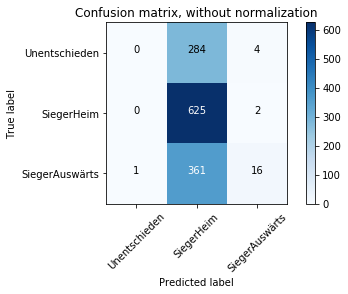

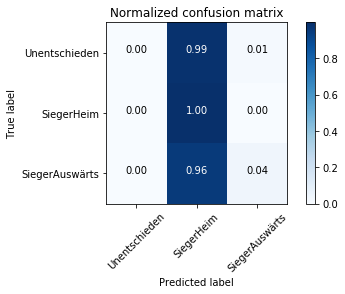

Richtigkeit: 0.485 (627) [SVC]


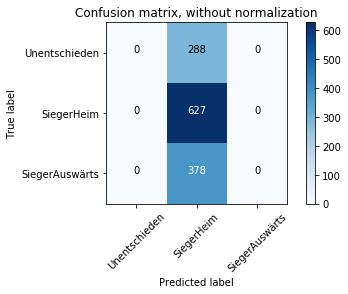

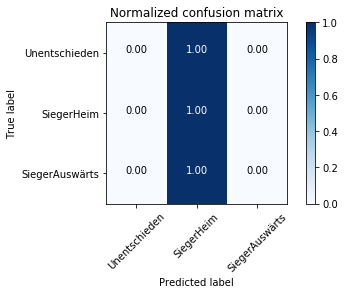

Richtigkeit: 0.488 (631) [NuSVC]


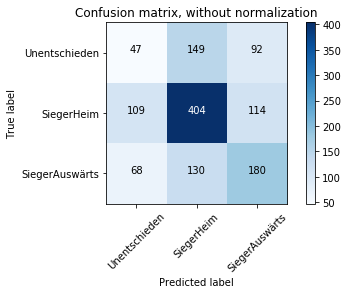

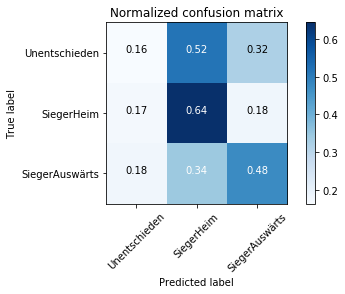

Richtigkeit: 0.491 (635) [RandomForestClassifier]


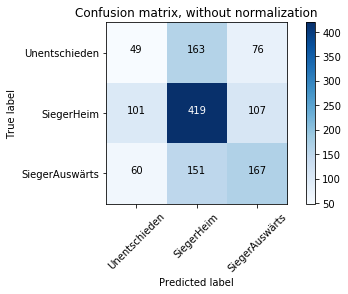

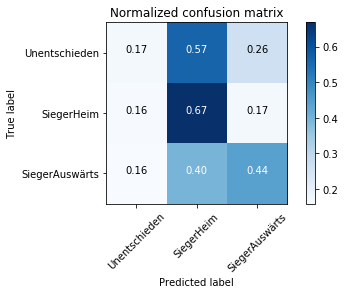

In [119]:
for i, clf in enumerate(classifierResult):
    c = clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy_number = accuracy_score(y_test, y_predict, normalize=False)
    accuracy_percent = accuracy_score(y_test, y_predict)
    
    class_names = ('Unentschieden', 'SiegerHeim', 'SiegerAuswärts')
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    print("Richtigkeit: %0.3f (%d) [%s]" % (accuracy_percent, accuracy_number, type(c).__name__))
    
    plt.show()

# WM 2018 KO-Runde